<CENTER><div style="display: flex; background-color: RGB(255,204,50);" >
<h1 style="margin: auto; padding: 30px; ">NATURAL LANGUAGE PROCESSING WITH DISASTER TWEETS<br><br>MODELISATION</h1>
</div>

# Objectif du Notebook

L'objectif de ce notebook est de réaliser une modélisation efficace pour notre jeu de données. Pour cela, plusieurs modèles de classification ont été testés afin de déterminer celui qui offre la meilleure performance. Les modèles testés incluent :

- Régression Logistique (Logistic Regression)
- Bernoulli Naive Bayes
- Classificateur KNN (K-Nearest Neighbors)
- Classificateur Perceptron
- Arbre de Décision (Decision Tree)
- Perceptron Multicouche (Multilayer Perceptron)

Chaque modèle a été évalué à l'aide de différentes métriques, notamment le score F-beta, afin de sélectionner le modèle le plus performant. Le choix final du meilleur modèle repose sur les résultats obtenus sur les jeux de données d'entraînement et de test.


# Importation

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer, fbeta_score 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             roc_auc_score,
                             confusion_matrix,
                            )
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
import warnings
import pyLDAvis.gensim_models
import pyLDAvis
# filter warnings
warnings.filterwarnings('ignore')

C:\Users\user\AppData\Local\Temp\ipykernel_21496\1146071998.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
# Définition du répertoire de travail
HOME_DIR = Path.cwd().parent
DATA_DIR = Path(HOME_DIR, "data")
print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Work directory: C:\Users\user\Documents\Jupyter\ML2\Projet\drive-download-20240606T173343Z-001 
Data directory: C:\Users\user\Documents\Jupyter\ML2\Projet\drive-download-20240606T173343Z-001\data


In [3]:
# importation de la base
train_data = pd.read_csv(Path(DATA_DIR, "Usefuldata.csv"), sep=",")
test_data = pd.read_csv(Path(DATA_DIR, "test.csv"), sep=",")

# **Modélisation**

Elle peut se faire de 2 manières :
- Dans le cas présent, étant donné que le prétraitement à déjà été effectué, on peut continuer ainsi, faire une vectorisation et une modélisation simultanément dans le pipeline
- Dans un autre cas et dans une optique de déployement, il serait possible d'intégrer le prétraitement dans le pipeline

### **Test de modélisation**

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# stopwords of english language
stopwords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### **Vectorisation**

In [5]:
# get all tweets (corpus)
target = train_data.target
corpus_none = train_data.text_sanitize # corpus non normalisé
corpus_stem = train_data.text_sanitize_stem # corpus normalisé par stemmatisation
corpus_lemma = train_data.text_sanitize_lemma # corpus normalisé par lemmatisation
corpus_lemma_stem = train_data.text_sanitize_lemma_stem # corpus normalisé par lemmatisation et ensuite par stemmatisation

**Vectoriser avec le Bag of Word**

In [6]:
# vectorisation avec BoW en utilisant un corpus non normalisé et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_none = count_vect.fit_transform(corpus_none)

In [7]:
# vectorisation avec BoW en utilisant un corpus non normalisé et des token unigramme et bigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,2))
X_train_12none = count_vect.fit_transform(corpus_none)

In [8]:
# vectorisation avec BoW en utilisant un corpus normalisé par stemmatisation et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_strem = count_vect.fit_transform(corpus_stem)

In [9]:
# vectorisation avec BoW en utilisant un corpus normalisé par lemmatisation et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_lemma = count_vect.fit_transform(corpus_lemma)

In [10]:
# vectorisation avec BoW en utilisant un corpus normalisé par lemmatisation et par stemmatisation et des token unigramme
count_vect = CountVectorizer(binary=True, ngram_range = (1,1))
X_train_lemma_stem = count_vect.fit_transform(corpus_lemma_stem)

**Vectoriser avec Td-IDF**

In [11]:
# vectorisation avec TF-IDF en utilisant un corpus non normalisé et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFnone = tfidf_vectorizer.fit_transform(corpus_none)

In [12]:
# vectorisation avec TF-IDF en utilisant un corpus non normalisé et des token unigramme et bigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 2))
X_train_TF12none = tfidf_vectorizer.fit_transform(corpus_none)

In [13]:
# vectorisation avec TF-IDF en utilisant un corpus normalisé par stemmatisation et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFstrem = tfidf_vectorizer.fit_transform(corpus_stem)

In [14]:
# vectorisation avec TF-IDF en utilisant un corpus normalisé par lemmatisation et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFlemma = tfidf_vectorizer.fit_transform(corpus_lemma)

In [15]:
# vectorisation avec TF-IDF en utilisant un corpus normalisé par lemmatisation et par stemmatisation et des token unigramme
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_nltk), max_df=0.95,
                                   min_df=0.025, ngram_range=(1, 1))
X_train_TFlemma_stem = tfidf_vectorizer.fit_transform(corpus_lemma_stem)

#### **Modélisation**

***BoW***

In [16]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, confusion_matrix)

# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_none, target)
# train prediction
y_train_pred = clf.predict(X_train_none)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4305
           1       0.95      0.81      0.87      3198

    accuracy                           0.90      7503
   macro avg       0.91      0.89      0.89      7503
weighted avg       0.90      0.90      0.90      7503

F-beta score (beta=1.75): 0.839172181134034


In [17]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_12none, target)
# train prediction
y_train_pred = clf.predict(X_train_12none)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4305
           1       0.99      0.85      0.91      3198

    accuracy                           0.93      7503
   macro avg       0.94      0.92      0.93      7503
weighted avg       0.94      0.93      0.93      7503

F-beta score (beta=1.75): 0.8791049982558428


In [18]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_strem, target)
# train prediction
y_train_pred = clf.predict(X_train_strem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4305
           1       0.93      0.80      0.86      3198

    accuracy                           0.89      7503
   macro avg       0.90      0.88      0.88      7503
weighted avg       0.89      0.89      0.89      7503

F-beta score (beta=1.75): 0.8264609271258698


In [19]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_lemma, target)
# train prediction
y_train_pred = clf.predict(X_train_lemma)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4305
           1       0.95      0.80      0.87      3198

    accuracy                           0.90      7503
   macro avg       0.91      0.88      0.89      7503
weighted avg       0.90      0.90      0.90      7503

F-beta score (beta=1.75): 0.8342746328931717


In [20]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_lemma_stem, target)
# train prediction
y_train_pred = clf.predict(X_train_lemma_stem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4305
           1       0.93      0.80      0.86      3198

    accuracy                           0.89      7503
   macro avg       0.90      0.88      0.88      7503
weighted avg       0.89      0.89      0.89      7503

F-beta score (beta=1.75): 0.8256853248115045


***TF-IDF***

In [21]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFnone, target)
# train prediction
y_train_pred = clf.predict(X_train_TFnone)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.59      0.97      0.73      4305
           1       0.64      0.08      0.15      3198

    accuracy                           0.59      7503
   macro avg       0.61      0.52      0.44      7503
weighted avg       0.61      0.59      0.48      7503

F-beta score (beta=1.75): 0.10508653104216933


In [22]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TF12none, target)
# train prediction
y_train_pred = clf.predict(X_train_TF12none)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.59      0.97      0.73      4305
           1       0.64      0.08      0.15      3198

    accuracy                           0.59      7503
   macro avg       0.61      0.52      0.44      7503
weighted avg       0.61      0.59      0.48      7503

F-beta score (beta=1.75): 0.10508653104216933


In [23]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFstrem, target)
# train prediction
y_train_pred = clf.predict(X_train_TFstrem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.61      0.94      0.74      4305
           1       0.69      0.18      0.29      3198

    accuracy                           0.62      7503
   macro avg       0.65      0.56      0.51      7503
weighted avg       0.64      0.62      0.55      7503

F-beta score (beta=1.75): 0.22023788515158998


In [24]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFlemma, target)
# train prediction
y_train_pred = clf.predict(X_train_TFlemma)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.60      0.95      0.73      4305
           1       0.66      0.13      0.22      3198

    accuracy                           0.60      7503
   macro avg       0.63      0.54      0.47      7503
weighted avg       0.62      0.60      0.51      7503

F-beta score (beta=1.75): 0.16243962076446405


In [25]:
# Création et entraînement du classifieur
clf = BernoulliNB().fit(X_train_TFlemma_stem, target)
# train prediction
y_train_pred = clf.predict(X_train_TFlemma_stem)
# train report
print(classification_report(target, y_train_pred))

fbeta = fbeta_score(target, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.61      0.94      0.74      4305
           1       0.69      0.18      0.29      3198

    accuracy                           0.62      7503
   macro avg       0.65      0.56      0.51      7503
weighted avg       0.64      0.62      0.55      7503

F-beta score (beta=1.75): 0.21991762283024416


Voyant les résultats ci-dessus, on soupçonne que la vectorisation par TF-IDF est peu efficace dans notre contexte. De plus on a un meilleur score avec un mélange d'unigrammes et de bigrammes.

## **Définition d'un pipeline**

Ledit pipeline intègrera le prétraitement d'un texte brute en sélectionnant les paramètres de prétraitement à utiliser. Il intègrera également le choix de la methode de vectorisation à utiliser ainsi que le modèle à entrainer.

**Fonction de vectorisation à inclure dans le pipeline**

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class VectorizerSelector_ok(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer='tfidf', maxdf=0.95, mindf=0.01, stopwords=None, ngram_range=(1, 1)):
        self.vectorizer = vectorizer
        self.maxdf = maxdf
        self.mindf = mindf
        self.stopwords = stopwords
        self.ngram_range = ngram_range

    def fit(self, X, y=None):
        if self.vectorizer == 'tfidf':
            self.vectorizer_ = TfidfVectorizer(max_df=self.maxdf, min_df=self.mindf, stop_words=self.stopwords, ngram_range=self.ngram_range)
        elif self.vectorizer == 'count':
            self.vectorizer_ = CountVectorizer(ngram_range=self.ngram_range, binary=True, stop_words=self.stopwords)
        self.vectorizer_.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer_.transform(X)


**Fonction de Text-Preprocessing à inclure dans le pipeline**

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

# fonction de préprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, language="english", stopwords_list=None, normalizer="stem"):
        self.language = language
        self.stopwords_list = stopwords_list
        self.normalizer = normalizer

    def preprocess_text(self, text):
        # Paramètres de prétraitement
        language = self.language
        stopwords_list = self.stopwords_list
        normalizer = self.normalizer

        # Votre fonction de prétraitement ici
        valid_normalizer = (None, "stem", "lemma")
        if not normalizer in valid_normalizer:
            raise ValueError(f"`normalizer` must be in `{valid_normalizer}`")
        # lower case
        text = text.lower()

        # delete html balise
        # We can also use BeautifulSoup package to get the text from HTML document
        text = re.sub(re.compile('<.*?>'), '', text)

        # remove url
        text = re.sub(r'(http|www)\S*', '', text)

        # delete email
        text = re.sub(r"\S*@\S*\s*", "", text)

        # delete special character
        text = re.sub(r'[^\w\s]', '', text)

        # delete number
        text = re.sub(r'[0-9]+','', text).strip()

        # tokenizer
        text_tokens = word_tokenize(text)

        # remove stopword
        if isinstance(stopwords_list, (set, list, tuple)):
            # split sentence word by word
            text_tokens = [word for word in text_tokens if word not in stopwords_list]

        # stem string: snowball stemmer
        if normalizer == "stem":
            stemmer = SnowballStemmer(language, ignore_stopwords=True)
            text_tokens = [stemmer.stem(wrd) for wrd in text_tokens]
        elif normalizer == "lemma":
            lemmatizer = WordNetLemmatizer()
            text_tokens = [lemmatizer.lemmatize(wrd) for wrd in text_tokens]

        return " ".join(text_tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.preprocess_text(text) for text in X]

## **Subdivision du dataset en `train` et `test`**

In [28]:
from sklearn.model_selection import train_test_split

#array.reshape(-1, 1)
#Splitting train_data as train, test, validation
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)

# Logistic regression

### Construction d'un pipeline pour la régression logistique

In [29]:
from sklearn.pipeline import Pipeline

# Whole / Complete Pipeline
LR_pipe = Pipeline([
        ('preprocessor', TextPreprocessor()),
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', LogisticRegression(random_state=42))
    ])

LR_pipe

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', LogisticRegression(random_state=42))])

### **Fiting & Performances**

### Entrainement du modèle

In [30]:
LR_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', LogisticRegression(random_state=42))])

**Prédiction**

In [31]:
LR_predicted = LR_pipe.predict(X_test)

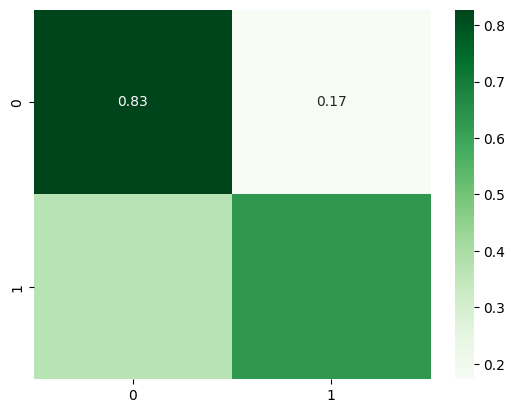

In [32]:
# Mateice de confusion
sns.heatmap(confusion_matrix(y_test, LR_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [33]:
# Rapport de classification
print(classification_report(y_test, LR_predicted,
                            target_names={"nodisaster" : 0, "disaster" : 1}))

fbeta = fbeta_score(y_test, LR_predicted, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

  nodisaster       0.76      0.83      0.79       874
    disaster       0.72      0.63      0.67       627

    accuracy                           0.75      1501
   macro avg       0.74      0.73      0.73      1501
weighted avg       0.74      0.75      0.74      1501

F-beta score (beta=1.75): 0.6520582647245092


### **Optimisation du modèle**

**Définition du pipeline pour la reherche des hyperparamètres**

In [34]:
# Restricted Pipeline
RPipeline_LR = Pipeline([
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', LogisticRegression(random_state=42))
    ])

RPipeline_LR

Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                ('classifier', LogisticRegression(random_state=42))])

**Hyperparamètres**

In [35]:
# Définissons la grille de paramètres
grid_params_LR = {
    # CustomTransformer hyperparmeters
    #'costom_transformer__normalizer' : (None, "stem", "lemma"),
    # vectorizer hyperparmeters
    "vectorizer__maxdf": (0.75, 0.9, 1.0),
    "vectorizer__mindf": (0.01, 0.05, 0.5),
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    # classifier hyperparameters
    'classifier__penalty' : ('l1', 'l2'),
    'classifier__tol' : (1e-5, 1e-4, 1e-3),
    'classifier__solver' : ('newton-cg', 'sag', 'saga', 'lbfgs'),
}


# Création d'un scorer personnalisé pour F-beta avec beta=1.75
fbeta_scorer = make_scorer(fbeta_score, beta=1.75, average='weighted')

# Création d'un StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Effectuons la recherche par grille
grid_search_LR = GridSearchCV(RPipeline_LR, grid_params_LR, cv=skf, n_jobs=-1, verbose=1, scoring=fbeta_scorer)

In [36]:
%%time
grid_search_LR.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
CPU times: total: 25.2 s
Wall time: 6min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__penalty': ('l1', 'l2'),
                         'classifier__solver': ('newton-cg', 'sag', 'saga',
                                                'lbfgs'),
                         'classifier__tol': (1e-05, 0.0001, 0.001),
                         'vectorizer__maxdf': (0.75, 0.9, 1.0),
                         'vectorizer__mindf': (0.01, 0.05, 0.5),
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring=make_scorer(fbeta_score, beta=1.75, average=weighted),
             verbose=1)

In [37]:
print(f"Best f_1.75 score: {grid_search_LR.best_score_}")
best_params = grid_search_LR.best_params_
print(f"\nBest parameters: \n{best_params}")

Best f_1.75 score: 0.7364171847768242

Best parameters: 
{'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'classifier__tol': 1e-05, 'vectorizer__maxdf': 0.75, 'vectorizer__mindf': 0.01, 'vectorizer__ngram_range': (1, 2)}


**Meilleur prédicteur**

In [38]:
best_LR_predicted = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', VectorizerSelector_ok(
        maxdf=best_params.get("vectorizer__maxdf"),
        mindf=best_params.get("vectorizer__mindf"),
        ngram_range=best_params.get("vectorizer__ngram_range"),
        stopwords=best_params.get("vectorizer__stopwords") 
    )),
    ('classifier', LogisticRegression(
        penalty=best_params.get("classifier__penalty"),
        tol=best_params.get("classifier__tol"),
        solver=best_params.get("classifier__solver")
    ))
])
best_LR_predicted

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer',
                 VectorizerSelector_ok(maxdf=0.75, ngram_range=(1, 2))),
                ('classifier',
                 LogisticRegression(penalty='l1', solver='saga', tol=1e-05))])

**Evaluation d'apprentissage**

In [39]:
# train prediction
y_train_pred = best_LR_predicted.fit(X_train, y_train).predict(X_train)


In [40]:
# train report
print(classification_report(y_train, y_train_pred))
# f_beta score
fbeta = fbeta_score(y_train, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.77      0.87      0.81      3431
           1       0.79      0.65      0.71      2571

    accuracy                           0.77      6002
   macro avg       0.78      0.76      0.76      6002
weighted avg       0.78      0.77      0.77      6002

F-beta score (beta=1.75): 0.6756122148684778


**Evaluation de prédiction**

In [42]:
# test set
print(classification_report(y_test, best_LR_predicted.predict(X_test)))

fbeta = fbeta_score(y_test, best_LR_predicted.predict(X_test), beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.76      0.84      0.79       874
           1       0.73      0.62      0.67       627

    accuracy                           0.75      1501
   macro avg       0.74      0.73      0.73      1501
weighted avg       0.75      0.75      0.74      1501

F-beta score (beta=1.75): 0.6472355922275702


In [43]:
from joblib import dump

# Exporter le pipeline vers un fichier
dump(best_LR_predicted, 'LR.pkl')

['LR.pkl']

# BernoulliNB

**Définition du pipeline avec prétraitement**

In [44]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, confusion_matrix)
from sklearn.pipeline import Pipeline

# Whole / Complete Pipeline
WPipeline_NB = Pipeline([
        ('preprocessor', TextPreprocessor()),
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', BernoulliNB())
    ])

WPipeline_NB

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', BernoulliNB())])

### **Fiting & Performances**

### Entrainement du modèle

In [45]:
WPipeline_NB.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', BernoulliNB())])

Prédiction

In [46]:
NB_predicted = WPipeline_NB.predict(X_test)

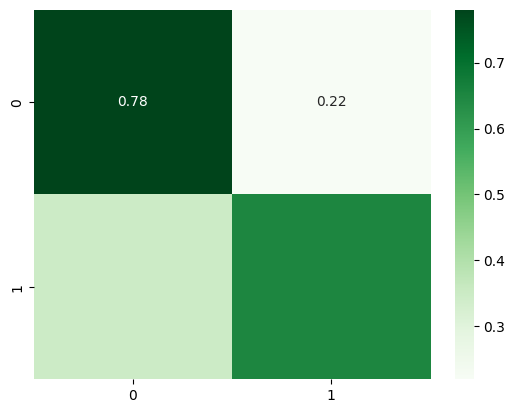

In [47]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, NB_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [48]:
# Rapport de classification
print(classification_report(y_test, NB_predicted,
                            target_names={"nodisaster" : 0, "disaster" : 1}))

fbeta = fbeta_score(y_test, NB_predicted, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

  nodisaster       0.76      0.78      0.77       874
    disaster       0.68      0.65      0.67       627

    accuracy                           0.73      1501
   macro avg       0.72      0.72      0.72      1501
weighted avg       0.73      0.73      0.73      1501

F-beta score (beta=1.75): 0.6590396390589752


### **Optimisation du modèle**

**Définition du pipeline sans prétraitement**

In [49]:
# Restricted Pipeline
RPipeline_NB = Pipeline([
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', BernoulliNB())
    ])

RPipeline_NB

Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                ('classifier', BernoulliNB())])

**Hyperparamètres**

In [50]:
from nltk.corpus import stopwords
stopwords_nltk = stopwords.words('english')
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

# Définissons la grille de paramètres
param_grid = {
    'vectorizer__vectorizer': ['tfidf', 'count'],
    'vectorizer__stopwords': [None, list(stopwords_nltk)],
    'vectorizer__maxdf': [0.85, 0.90, 0.95],
    'vectorizer__mindf': [0.01, 0.02, 0.025],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__alpha': [0.05, 0.1, 0.2, 0.5, 1.0, 10.0]
}

# Créons un scorer personnalisé pour F-beta avec beta=1.75
fbeta_scorer = make_scorer(fbeta_score, beta=1.75, average='weighted')

# Créons un StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Effectuons la recherche par grille
grid_search = GridSearchCV(RPipeline_NB, param_grid, cv=skf, n_jobs=-1, verbose=1, scoring=fbeta_scorer)

**Optimisation**

In [51]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
CPU times: total: 44.1 s
Wall time: 13min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                                       ('classifier', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.05, 0.1, 0.2, 0.5, 1.0, 10.0],
                         'vectorizer__maxdf': [0.85, 0.9, 0.95],
                         'vectorizer__mindf': [0.01, 0.02, 0.025],
                         'vectorizer__ngram_range': [(1, 1), (1, 2...
                         'vectorizer__stopwords': [None,
                                                   ['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                                    "you're", "you've",
                                                    "you'll", "you'd", 'your',
                                                    'yours', 'yourself',
                                                    'yourselves', 'he', 'him',
                                                    'his', 'himself', 'she',
                                                    "she's", 'her', 'hers',
                                                    'herself', 'it', "it's",
                                                    'its', 'itself', ...]],
                         'vectorizer__vectorizer': ['tfidf', 'count']},
             scoring=make_scorer(fbeta_score, beta=1.75, average=weighted),
             verbose=1)

In [52]:
print(f"Best f_1.75 score: {grid_search.best_score_}")
best_params = grid_search.best_params_
print(f"\nBest parameters: \n{best_params}")

Best f_1.75 score: 0.7995451142054822

Best parameters: 
{'classifier__alpha': 0.5, 'vectorizer__maxdf': 0.85, 'vectorizer__mindf': 0.01, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stopwords': None, 'vectorizer__vectorizer': 'count'}


**Meilleur prédicteur**

In [53]:
best_NB_predicted = Pipeline([
    # Preprocessing
    ('preprocessor', TextPreprocessor()),
    # Vectorisation
    ('vectorizer', VectorizerSelector_ok(
        vectorizer=best_params.get("vectorizer__vectorizer"),
        maxdf=best_params.get("vectorizer__maxdf"),
        mindf=best_params.get("vectorizer__mindf"),
        ngram_range=best_params.get("vectorizer__ngram_range"),
        stopwords=best_params.get("vectorizer__stopwords") #stopwords.words('english')  # Ajouter les stopwords ici si nécessaire
    )),
    # Le modèle de classification
    ('classifier', BernoulliNB(
        alpha=best_params.get("classifier__alpha")  # Correction : BernoulliNB utilise 'alpha'
    ))
])
best_NB_predicted

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer',
                 VectorizerSelector_ok(maxdf=0.85, vectorizer='count')),
                ('classifier', BernoulliNB(alpha=0.5))])

### Reentrainement du modèle

In [54]:
# train prediction
y_train_pred = best_NB_predicted.fit(X_train, y_train).predict(X_train)

**Evaluation d'apprentissage**

In [55]:
# train report
print(classification_report(y_train, y_train_pred))
# f_beta score
fbeta = fbeta_score(y_train, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      3431
           1       0.93      0.83      0.88      2571

    accuracy                           0.90      6002
   macro avg       0.91      0.89      0.90      6002
weighted avg       0.90      0.90      0.90      6002

F-beta score (beta=1.75): 0.8549953022236142


**Evaluation de prédiction**

In [56]:
# test set
print(classification_report(y_test, best_NB_predicted.predict(X_test)))

fbeta = fbeta_score(y_test, best_NB_predicted.predict(X_test), beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.80      0.67      0.73       627

    accuracy                           0.79      1501
   macro avg       0.79      0.77      0.78      1501
weighted avg       0.79      0.79      0.79      1501

F-beta score (beta=1.75): 0.6944763949594868


In [57]:
dump(best_NB_predicted, 'BernoulliNB.pkl')

['BernoulliNB.pkl']

# Decision Tree

**Définition du pipeline avec prétraitement**

### Construction du pipeline pour Decision Tree

In [58]:

# Whole / Complete Pipeline
dtcf_pipe = Pipeline([
        # Preprocessing
        ('preprocessor', TextPreprocessor()),
        # Vectorisation
        ('vectorizer', VectorizerSelector_ok()),
        # Le modèle de classification
        ('classifier', DecisionTreeClassifier()),  # DecisionTreeClassifier

    ])

dtcf_pipe

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', DecisionTreeClassifier())])

### **Fiting & Performances**

### Entrainement du modèle

In [59]:
dtcf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', DecisionTreeClassifier())])

Prédiction

In [60]:
dtcf_predicted = dtcf_pipe.predict(X_test)

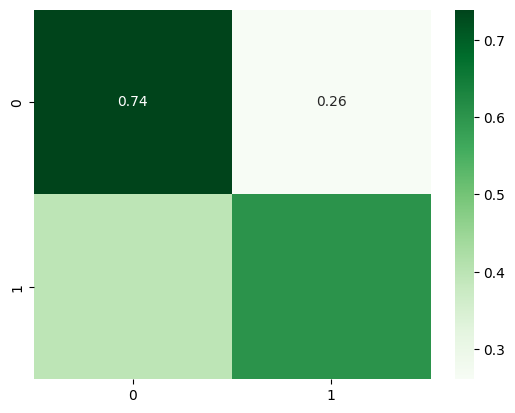

In [61]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, dtcf_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [62]:
# Rapport de classification
print(classification_report(y_test, dtcf_predicted,
                            target_names={"nodisaster" : 0, "disaster" : 1}))

fbeta = fbeta_score(y_test, dtcf_predicted, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

  nodisaster       0.72      0.74      0.73       874
    disaster       0.62      0.60      0.61       627

    accuracy                           0.68      1501
   macro avg       0.67      0.67      0.67      1501
weighted avg       0.68      0.68      0.68      1501

F-beta score (beta=1.75): 0.6092494126375664


### **Optimisation du modèle**

**Définition du pipeline sans prétraitement**

In [63]:
# Restricted Pipeline
RPipeline_dtcf = Pipeline([
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', DecisionTreeClassifier())
    ])

RPipeline_dtcf

Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                ('classifier', DecisionTreeClassifier())])

**Hyperparamètres**

In [64]:
grid_params = {
    # vectorizer hyperparmeters
    "vectorizer__maxdf": (0.75, 0.9, 1.0),
    "vectorizer__mindf": (0.01, 0.05, 0.5),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 1)],
    # classifier hyperparameters
    #'classifier__criterion': ("gini", "entropy"),
    'classifier__max_depth': (20, 25, 30),
    'classifier__min_samples_split' : (2, 5, 10),
    'classifier__min_samples_leaf' : (1, 5)
}

# Créons un scorer personnalisé pour F-beta avec beta=1.75
fbeta_scorer = make_scorer(fbeta_score, beta=1.75, average='weighted')

# Créons un StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Effectuons la recherche par grille
grid_search = GridSearchCV(RPipeline_dtcf, grid_params, cv=skf, n_jobs=-1, verbose=1, scoring=fbeta_scorer)

**Optimisation**

In [65]:
%%time
grid_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
CPU times: total: 30.5 s
Wall time: 6min 57s


In [66]:
print(f"Best f_1.75 score: {grid_search.best_score_}")
best_params = grid_search.best_params_
print(f"\nBest parameters: \n{best_params}")

Best f_1.75 score: 0.6937147482625303

Best parameters: 
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'vectorizer__maxdf': 1.0, 'vectorizer__mindf': 0.01, 'vectorizer__ngram_range': (1, 1)}


**Meilleur prédicteur**

In [67]:
best_dtcf_predicted = Pipeline([
    # Preprocessing
    ('preprocessor', TextPreprocessor()),
    # Vectorisation
    ('vectorizer', VectorizerSelector_ok(
        maxdf=best_params.get("vectorizer__maxdf"),
        mindf=best_params.get("vectorizer__mindf"),
        ngram_range=best_params.get("vectorizer__ngram_range"),
        stopwords=best_params.get("vectorizer__stopwords") 
    )),
    # Le modèle de classification
    ('classifier', DecisionTreeClassifier(
                                          max_depth=best_params.get("classifier__max_depth"),
                                          min_samples_split = best_params.get("classifier__min_samples_split"),
                                          min_samples_leaf = best_params.get("classifier__min_samples_leaf"),
                                )),
    ])
best_dtcf_predicted

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok(maxdf=1.0)),
                ('classifier', DecisionTreeClassifier(max_depth=20))])

### Reentrainement du modèle

In [68]:
# train prediction
y_train_pred = best_dtcf_predicted.fit(X_train, y_train).predict(X_train)

**Evaluation d'apprentissage**

In [69]:
# train report
print(classification_report(y_train, y_train_pred))
# f_beta score
fbeta = fbeta_score(y_train, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      3431
           1       0.89      0.61      0.72      2571

    accuracy                           0.80      6002
   macro avg       0.83      0.78      0.78      6002
weighted avg       0.82      0.80      0.79      6002

F-beta score (beta=1.75): 0.6609268169156748


**Evaluation de prédiction**

In [70]:
# test set
print(classification_report(y_test, best_dtcf_predicted.predict(X_test)))

fbeta = fbeta_score(y_test, best_dtcf_predicted.predict(X_test), beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       874
           1       0.71      0.47      0.57       627

    accuracy                           0.70      1501
   macro avg       0.70      0.67      0.67      1501
weighted avg       0.70      0.70      0.69      1501

F-beta score (beta=1.75): 0.516466465127478


In [71]:
dump(best_dtcf_predicted, 'DecisionTree.pkl')

['DecisionTree.pkl']

# KNN Classifier

**Définition du pipeline avec prétraitement**

### Construction du pipeline pour KNN Classifier

In [72]:
KNN_pipe = Pipeline([
        # Preprocessing
        ('preprocessor', TextPreprocessor()),
        # Vectorisation
        ('vectorizer', VectorizerSelector_ok()),
        # Le modèle de classification
        ('classifier', KNeighborsClassifier()),  # DecisionTreeClassifier

    ])

KNN_pipe

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', KNeighborsClassifier())])

### **Fiting & Performances**

### Entrainement du modèle

In [73]:
KNN_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', KNeighborsClassifier())])

Prédiction

In [74]:
KNN_predicted = KNN_pipe.predict(X_test)

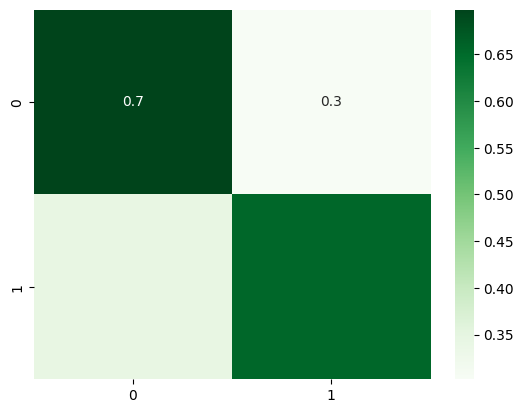

In [75]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, KNN_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [76]:
# Rapport de classification
print(classification_report(y_test, KNN_predicted,
                            target_names={"nodisaster" : 0, "disaster" : 1}))

fbeta = fbeta_score(y_test, KNN_predicted, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

  nodisaster       0.74      0.70      0.72       874
    disaster       0.61      0.66      0.63       627

    accuracy                           0.68      1501
   macro avg       0.67      0.68      0.67      1501
weighted avg       0.68      0.68      0.68      1501

F-beta score (beta=1.75): 0.6433783686149845


### **Optimisation du modèle**

**Définition du pipeline sans prétraitement**

In [77]:
# Restricted Pipeline
RPipeline_KNN = Pipeline([
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', KNeighborsClassifier())
    ])

RPipeline_KNN

Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                ('classifier', KNeighborsClassifier())])

**Hyperparamètres**

In [78]:
grid_params = {
    # vectorizer hyperparmeters
    "vectorizer__maxdf": (1.0, 0.75, 0.8),
    "vectorizer__mindf": (1.0, 0.01, 0.05),
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    # classifier hyperparameters
    'classifier__n_neighbors' : (3, 5, 7),
    'classifier__weights' : ('uniform', 'distance'),
    'classifier__p' : (1, 2),
    'classifier__leaf_size' : (10, 20, 30)
}

# Créons un scorer personnalisé pour F-beta avec beta=1.75
fbeta_scorer = make_scorer(fbeta_score, beta=1.75, average='weighted')

# Créons un StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Effectuons la recherche par grille
gs_KNN = GridSearchCV(RPipeline_KNN, grid_params, cv=skf, n_jobs=-1, verbose=1, scoring=fbeta_scorer)

**Optimisation**

In [79]:
%%time
gs_KNN = gs_KNN.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
CPU times: total: 41.9 s
Wall time: 16min 14s


In [80]:
print(f"Best f_1.75 score: {gs_KNN.best_score_}")
best_params = gs_KNN.best_params_
print(f"\nBest parameters: \n{best_params}")

Best f_1.75 score: 0.7087123755598314

Best parameters: 
{'classifier__leaf_size': 10, 'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'distance', 'vectorizer__maxdf': 1.0, 'vectorizer__mindf': 0.01, 'vectorizer__ngram_range': (1, 1)}


**Meilleur prédicteur**

In [81]:
best_KNN_predicted = Pipeline([
    # Preprocessing
    ('preprocessor', TextPreprocessor()),
    # Vectorisation
    ('vectorizer', VectorizerSelector_ok(
        maxdf=best_params.get("vectorizer__maxdf"),
        mindf=best_params.get("vectorizer__mindf"),
        ngram_range=best_params.get("vectorizer__ngram_range"),
        stopwords=best_params.get("vectorizer__stopwords") 
    )),
    # Le modèle de classification
    ('classifier', KNeighborsClassifier(
                                         n_neighbors=best_params.get("classifier__n_neighbors"),
                                         weights = best_params.get("classifier__weights"),
                                         p = best_params.get("classifier__p"),
                                         leaf_size = best_params.get("classifier__leaf_size")
                                )),
    ])
best_KNN_predicted

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok(maxdf=1.0)),
                ('classifier',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=7,
                                      weights='distance'))])

### Reentrainement du modèle

In [82]:
# train prediction
y_train_pred = best_KNN_predicted.fit(X_train, y_train).predict(X_train)

**Evaluation d'apprentissage**

In [83]:
# train report
print(classification_report(y_train, y_train_pred))
# f_beta score
fbeta = fbeta_score(y_train, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3431
           1       0.93      0.94      0.94      2571

    accuracy                           0.94      6002
   macro avg       0.94      0.94      0.94      6002
weighted avg       0.94      0.94      0.94      6002

F-beta score (beta=1.75): 0.940149046566627


**Evaluation de prédiction**

In [84]:
# test set
print(classification_report(y_test, best_KNN_predicted.predict(X_test)))

fbeta = fbeta_score(y_test, best_KNN_predicted.predict(X_test), beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       874
           1       0.61      0.66      0.64       627

    accuracy                           0.68      1501
   macro avg       0.68      0.68      0.68      1501
weighted avg       0.69      0.68      0.69      1501

F-beta score (beta=1.75): 0.6480745610866266


In [85]:
dump(best_KNN_predicted, 'KNN.pkl')

['KNN.pkl']

# Perceptron classifier

**Définition du pipeline avec prétraitement**

### Construction du pipeline pour Perceptron classifier

In [86]:
PC_pipe = Pipeline([
        # Preprocessing
        ('preprocessor', TextPreprocessor()),
        # Vectorisation
        ('vectorizer', VectorizerSelector_ok()),
        # Le modèle de classification
        ('classifier', Perceptron()),  # DecisionTreeClassifier

    ])

PC_pipe

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', Perceptron())])

### **Fiting & Performances**

### Entrainement du modèle

In [87]:
PC_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', Perceptron())])

Prédiction

In [88]:
PC_predicted = PC_pipe.predict(X_test)

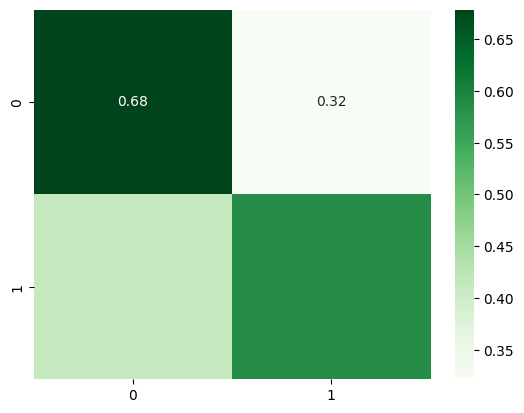

In [89]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, PC_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [90]:
# Rapport de classification
print(classification_report(y_test, PC_predicted,
                            target_names={"nodisaster" : 0, "disaster" : 1}))

fbeta = fbeta_score(y_test, PC_predicted, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

  nodisaster       0.70      0.68      0.69       874
    disaster       0.57      0.59      0.58       627

    accuracy                           0.64      1501
   macro avg       0.63      0.63      0.63      1501
weighted avg       0.64      0.64      0.64      1501

F-beta score (beta=1.75): 0.5818960274405819


### **Optimisation du modèle**

**Définition du pipeline sans prétraitement**

In [91]:
# Restricted Pipeline
RPipeline_PC = Pipeline([
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', Perceptron()),
    ])

RPipeline_PC

Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                ('classifier', Perceptron())])

**Hyperparamètres**

In [92]:
grid_params = {
    # vectorizer hyperparmeters
    "vectorizer__maxdf": (1.0, 0.75, 0.8),
    "vectorizer__mindf": (1.0, 0.01, 0.05),
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    # classifier hyperparameters
    'classifier__penalty' : ('l1','l2'),
    'classifier__max_iter': (50, 100, 500), 
    'classifier__validation_fraction' : (0.01, 0.05, 0.1),
    'classifier__n_iter_no_change' : (5, 7, 10),
   
}

# Créons un scorer personnalisé pour F-beta avec beta=1.75
fbeta_scorer = make_scorer(fbeta_score, beta=1.75, average='weighted')

# Créons un StratifiedKFold
skf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

# Effectuons la recherche par grille
gs_PC = GridSearchCV(RPipeline_PC, grid_params, cv=skf, n_jobs=-1, verbose=1, scoring=fbeta_scorer)

**Optimisation**

In [93]:
%%time
gs_PC = gs_PC.fit(X_train, y_train)

Fitting 4 folds for each of 972 candidates, totalling 3888 fits
CPU times: total: 52 s
Wall time: 11min 10s


In [94]:
print(f"Best f_1.75 score: {gs_PC.best_score_}")
best_params = gs_PC.best_params_
print(f"\nBest parameters: \n{best_params}")

Best f_1.75 score: 0.669923967612384

Best parameters: 
{'classifier__max_iter': 50, 'classifier__n_iter_no_change': 7, 'classifier__penalty': 'l1', 'classifier__validation_fraction': 0.01, 'vectorizer__maxdf': 1.0, 'vectorizer__mindf': 0.01, 'vectorizer__ngram_range': (1, 2)}


**Meilleur prédicteur**

In [95]:
best_PC_predicted = Pipeline([
    # Preprocessing
    ('preprocessor', TextPreprocessor()),
    # Vectorisation
    ('vectorizer', VectorizerSelector_ok(
        maxdf=best_params.get("vectorizer__maxdf"),
        mindf=best_params.get("vectorizer__mindf"),
        ngram_range=best_params.get("vectorizer__ngram_range"),
        stopwords=best_params.get("vectorizer__stopwords") 
    )),
    # Le modèle de classification
    ('classifier', Perceptron(
        penalty= best_params.get("classifier__penalty"),
        max_iter = best_params.get("classifier__max_iter"),
        validation_fraction = best_params.get("classifier__validation_fraction"),
        n_iter_no_change= best_params.get("classifier__n_iter_no_change")
    )),  

    ])
best_PC_predicted

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer',
                 VectorizerSelector_ok(maxdf=1.0, ngram_range=(1, 2))),
                ('classifier',
                 Perceptron(max_iter=50, n_iter_no_change=7, penalty='l1',
                            validation_fraction=0.01))])

### Reentrainement du modèle

In [96]:
# train prediction
y_train_pred = best_PC_predicted.fit(X_train, y_train).predict(X_train)

**Evaluation d'apprentissage**

In [97]:
# train report
print(classification_report(y_train, y_train_pred))
# f_beta score
fbeta = fbeta_score(y_train, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      3431
           1       0.69      0.47      0.56      2571

    accuracy                           0.68      6002
   macro avg       0.68      0.66      0.66      6002
weighted avg       0.68      0.68      0.67      6002

F-beta score (beta=1.75): 0.5107814700175852


**Evaluation de prédiction**

In [98]:
# test set
print(classification_report(y_test, best_PC_predicted.predict(X_test)))

fbeta = fbeta_score(y_test, best_PC_predicted.predict(X_test), beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.68      0.82      0.75       874
           1       0.66      0.47      0.55       627

    accuracy                           0.68      1501
   macro avg       0.67      0.65      0.65      1501
weighted avg       0.67      0.68      0.66      1501

F-beta score (beta=1.75): 0.5060568472724394


In [99]:
dump(best_PC_predicted, 'PC.pkl')

['PC.pkl']

# Perceptron multicouche

**Définition du pipeline avec prétraitement**

### Construction du pipeline pour MLPClassifier

In [100]:
MLP_pipe = Pipeline([
        # Preprocessing
        ('preprocessor', TextPreprocessor()),
        # Vectorisation
        ('vectorizer', VectorizerSelector_ok()),
        # Le modèle de classification
        ('classifier',  MLPClassifier()),  # DecisionTreeClassifier

    ])

MLP_pipe

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', MLPClassifier())])

### **Fiting & Performances**

### Entrainement du modèle

In [101]:
MLP_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok()),
                ('classifier', MLPClassifier())])

Prédiction

In [102]:
MLP_predicted = MLP_pipe.predict(X_test)

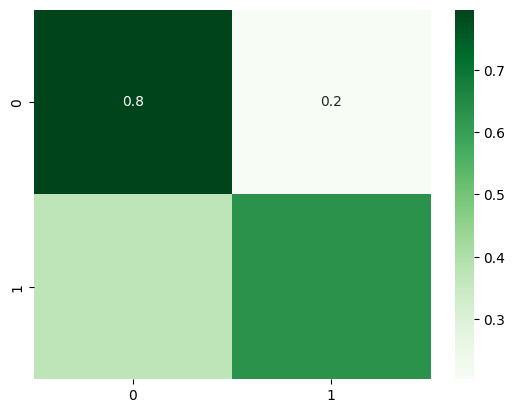

In [103]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, MLP_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [104]:
# Rapport de classification
print(classification_report(y_test, MLP_predicted,
                            target_names={"nodisaster" : 0, "disaster" : 1}))

fbeta = fbeta_score(y_test, MLP_predicted, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

  nodisaster       0.75      0.80      0.77       874
    disaster       0.69      0.63      0.66       627

    accuracy                           0.73      1501
   macro avg       0.72      0.71      0.72      1501
weighted avg       0.72      0.73      0.72      1501

F-beta score (beta=1.75): 0.6436288887217669


### **Optimisation du modèle**

**Définition du pipeline sans prétraitement**

In [105]:
# Restricted Pipeline
RPipeline_MLP = Pipeline([
        ('vectorizer', VectorizerSelector_ok()),
        ('classifier', MLPClassifier(solver='adam', random_state = 42))
    ])

RPipeline_MLP

Pipeline(steps=[('vectorizer', VectorizerSelector_ok()),
                ('classifier', MLPClassifier(random_state=42))])

**Hyperparamètres**

In [106]:
grid_params = {
    "vectorizer__mindf": (0.05, 0.1),
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': [0.0001,0.001,0.01],
    'classifier__learning_rate_init': [0.005, 0.01, 0.05],
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Créons un scorer personnalisé pour F-beta avec beta=1.75
fbeta_scorer = make_scorer(fbeta_score, beta=1.75, average='weighted')

# Créons un StratifiedKFold
skf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

# Effectuons la recherche par grille
gs_MLP = GridSearchCV(RPipeline_MLP, grid_params, cv=skf, n_jobs=-1, verbose=1, scoring=fbeta_scorer)

**Optimisation**

In [107]:
%%time
gs_MLP = gs_MLP.fit(X_train, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
CPU times: total: 17.2 s
Wall time: 15min 9s


In [108]:
print(f"Best f_1.75 score: {gs_MLP.best_score_}")
best_params = gs_MLP.best_params_
print(f"\nBest parameters: \n{best_params}")

Best f_1.75 score: 0.6579680830150407

Best parameters: 
{'classifier__alpha': 0.01, 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.05, 'vectorizer__mindf': 0.05, 'vectorizer__ngram_range': (1, 2)}


**Meilleur prédicteur**

In [109]:
best_MLP_predicted = Pipeline([
    # Preprocessing
    ('preprocessor', TextPreprocessor()),
    # Vectorisation
    ('vectorizer', VectorizerSelector_ok(
        maxdf= 0.75)),
    # Le modèle de classification
    ('classifier', MLPClassifier(
        solver = 'adam',
        #activation =  best_param.get("classifier__activation"),
        learning_rate =  best_params.get("classifier__learning_rate"), 
        alpha = best_params.get("classifier__alpha"),
        learning_rate_init = best_params.get("classifier__learning_rate_init"),
         random_state = 42
    ))

            ])
best_MLP_predicted

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer', VectorizerSelector_ok(maxdf=0.75)),
                ('classifier',
                 MLPClassifier(alpha=0.01, learning_rate_init=0.05,
                               random_state=42))])

### Reentrainement du modèle

In [110]:
# train prediction
y_train_pred = best_MLP_predicted.fit(X_train, y_train).predict(X_train)

**Evaluation d'apprentissage**

In [111]:
# train report
print(classification_report(y_train, y_train_pred))
# f_beta score
fbeta = fbeta_score(y_train, y_train_pred, beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3431
           1       0.91      0.77      0.83      2571

    accuracy                           0.87      6002
   macro avg       0.88      0.86      0.86      6002
weighted avg       0.87      0.87      0.87      6002

F-beta score (beta=1.75): 0.8027629692610361


**Evaluation de prédiction**

In [112]:
# test set
print(classification_report(y_test, best_MLP_predicted.predict(X_test)))

fbeta = fbeta_score(y_test, best_MLP_predicted.predict(X_test), beta=1.75)
print(f"F-beta score (beta=1.75): {fbeta}")

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       874
           1       0.68      0.60      0.64       627

    accuracy                           0.72      1501
   macro avg       0.71      0.70      0.70      1501
weighted avg       0.71      0.72      0.71      1501

F-beta score (beta=1.75): 0.6204075448829635


In [113]:
dump(best_MLP_predicted, 'MLP.pkl')

['MLP.pkl']

In [127]:
# Noms des fichiers contenant les modèles exportés
model_files = ['LR.pkl', 'BernoulliNB.pkl', 'DecisionTree.pkl', 'KNN.pkl', 'PC.pkl', 'MLP.pkl']  # Remplacez par vos fichiers
model_names = ['Logistic Regression', 'Bernoulli Naives Bayes', 'Decision Tree', 'KNN Classifier', 'Perceptron Classifier', 'Perceptron multicouche']  # Noms des modèles correspondants

In [119]:
# Charger les modèles dans une liste
import joblib
models = [joblib.load(file) for file in model_files]


In [120]:
# Initialiser les listes pour stocker les scores
fbeta_scores_train = []
fbeta_scores_test = []

# Définissons la valeur de beta pour le F-beta score
beta = 1.75


In [121]:
# Calculer les F-beta scores pour chaque modèle
for model, name in zip(models, model_names):
    y_train_pred = model.fit(X_train, y_train).predict(X_train)
    y_test_pred = model.predict(X_test)
    
    fbeta_train = fbeta_score(y_train, y_train_pred, beta=beta)
    fbeta_test = fbeta_score(y_test, y_test_pred, beta=beta)
    
    fbeta_scores_train.append(fbeta_train)
    fbeta_scores_test.append(fbeta_test)
    
    print(f"Model: {name}")
    print(f"Train F-beta score: {fbeta_train}")
    print(f"Test F-beta score: {fbeta_test}")
    print("-" * 30)

Model: Logistic Regression
Train F-beta score: 0.6756122148684778
Test F-beta score: 0.6469719726090165
------------------------------
Model: Bernoulli Naives Bayes
Train F-beta score: 0.8549953022236142
Test F-beta score: 0.6944763949594868
------------------------------
Model: Decision Tree
Train F-beta score: 0.6606420356022573
Test F-beta score: 0.5227000399414192
------------------------------
Model: KNN Classifier
Train F-beta score: 0.940149046566627
Test F-beta score: 0.6480745610866266
------------------------------
Model: Preceptron Classifier
Train F-beta score: 0.5107814700175852
Test F-beta score: 0.5060568472724394
------------------------------
Model: Perceptron multicouche
Train F-beta score: 0.8027629692610361
Test F-beta score: 0.6204075448829635
------------------------------


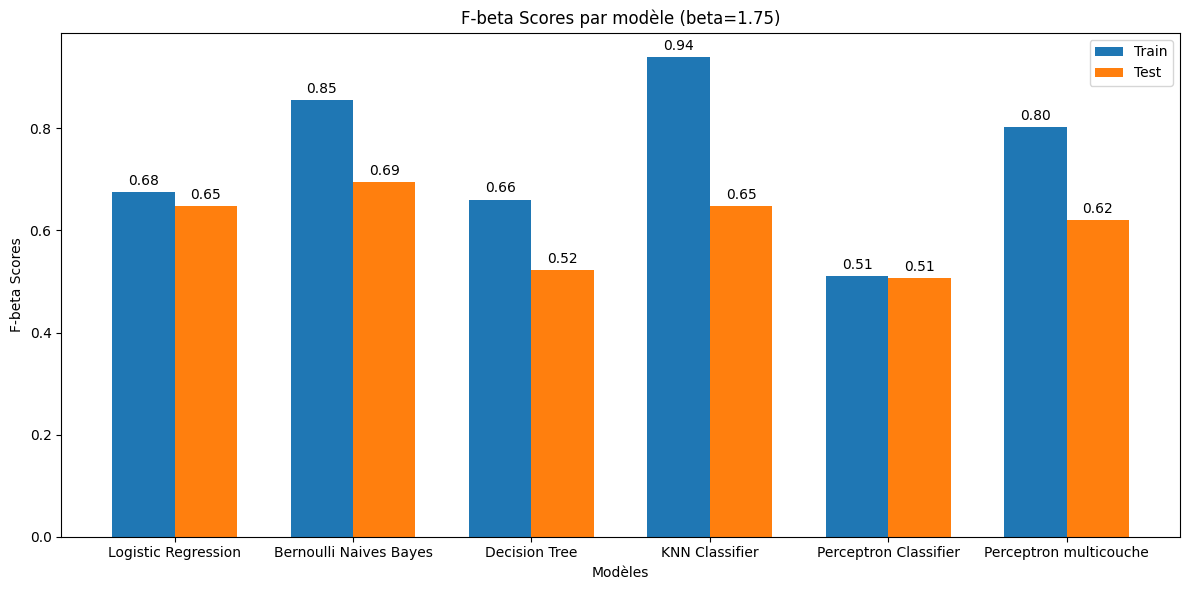

In [132]:
import numpy as np
# Visualisons les résultats
x = np.arange(len(models)) 
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, fbeta_scores_train, width, label='Train')
rects2 = ax.bar(x + width/2, fbeta_scores_test, width, label='Test')

# Ajout de quelques textes pour les labels, titres...
ax.set_xlabel('Modèles')
ax.set_ylabel('F-beta Scores')
ax.set_title(f'F-beta Scores par modèle (beta={beta})')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Fonction pour ajouter les labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()

plt.show()

In [129]:
# Sélection du meilleur modèle
best_model_index = np.argmax(fbeta_scores_test)
best_model = models[best_model_index]
print(f"Le meilleur modèle est {model_names[best_model_index]} avec un F-{beta} score de {fbeta_scores_test[best_model_index]:.2f} sur le jeu de test.")

Le meilleur modèle est Bernoulli Naives Bayes avec un F-1.75 score de 0.69 sur le jeu de test.


# Prédiction et submission

In [133]:
predictions = best_NB_predicted.predict(test_data['text'])

In [137]:
import pandas as pd

# Fichier submission.csv existant pour obtenir les valeurs des id
submission_existante = pd.read_csv(Path(DATA_DIR, 'sample_submission.csv'), sep=",")

# DataFrame pour les nouvelles prédictions avec les valeurs correspondantes des id
# En supposant que test_data['id'] contient les valeurs des id et predictions est votre nouveau tableau de prédictions
nouvelles_predictions = pd.DataFrame({'id': test_data['id'], 'target': predictions})

# Fusionn des nouvelles prédictions avec le DataFrame de soumission existant sur 'id'
submission_mise_a_jour = pd.merge(submission_existante[['id']], nouvelles_predictions, on='id', how='left')

# Étape 4 : Enregistrer le DataFrame mis à jour dans submission.csv
chemin_vers_fichier = Path(DATA_DIR, "sample_submission.csv")
submission_mise_a_jour.to_csv(chemin_vers_fichier)